In [56]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, TargetEncoder
import category_encoders as ce
from sklearn.impute import KNNImputer
from sklearn.feature_selection import chi2, SelectKBest
import scipy.stats as stats
from scipy.stats import chi2_contingency
import re
from matplotlib.ticker import MaxNLocator
import warnings

warnings.filterwarnings('ignore')


In [57]:
sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))
import data_utils

In [58]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
df_train_processed = pd.read_csv("./data/train_preprocessed.csv")

In [59]:
df_train_category = data_utils.get_categorical_cols_info(df_train)
df_train_category

,col_name,col_category,category_count
0,brand,Ford,23088
1,brand,Mercedes-Benz,19172
2,brand,BMW,17028
3,brand,Chevrolet,16335
4,brand,Audi,10887
...,...,...,...
3606,accident,None reported,144514
3607,accident,At least 1 accident or damage reported,41567
3608,accident,NaN,2452
3609,clean_title,Yes,167114


In [81]:
df_test_category = data_utils.get_categorical_cols_info(df_test)

In [82]:
df_test_category.head()

,col_name,col_category,category_count
0,brand,Ford,15265
1,brand,Mercedes-Benz,12875
2,brand,BMW,11286
3,brand,Chevrolet,10698
4,brand,Audi,7289


In [85]:
# for each column find categories in test that are not in train
# Step 1: Collect unique categories for each column from train and test
train_categories = df_train_category.groupby('col_name')['col_category'].apply(set).reset_index(name='train_categories')
test_categories = df_test_category.groupby('col_name')['col_category'].apply(set).reset_index(name='test_categories')
# Step 2: Merge the two dataframes on 'col_name' to compare categories
category_comparison = pd.merge(train_categories, test_categories, on='col_name', how='outer')

# Step 3: Find missing categories in train but present in test, and vice versa
category_comparison['missing_in_train'] = category_comparison.apply(
    lambda row: row['test_categories'] - row['train_categories'] if pd.notnull(row['test_categories']) and pd.notnull(row['train_categories']) else set(),
    axis=1
)
category_comparison['missing_in_test'] = category_comparison.apply(
    lambda row: row['train_categories'] - row['test_categories'] if pd.notnull(row['test_categories']) and pd.notnull(row['train_categories']) else set(),
    axis=1
)

# Handling cases where one of the columns has missing values
category_comparison['missing_in_train'] = category_comparison['missing_in_train'].apply(lambda x: x if isinstance(x, set) else set())
category_comparison['missing_in_test'] = category_comparison['missing_in_test'].apply(lambda x: x if isinstance(x, set) else set())

       col_name                                   missing_in_train  \
0      accident                                                 {}   
1         brand                                                 {}   
2   clean_title                                                 {}   
3        engine  {177.0HP 1.6L 4 Cylinder Engine Plug-In Electr...   
4       ext_col                                                 {}   
5     fuel_type                                                 {}   
6       int_col                                                 {}   
7         model                                     {allroad 2.7T}   
8  transmission                                                 {}   

                                     missing_in_test  
0                                                 {}  
1                                  {smart, Polestar}  
2                                                 {}  
3  {313.0HP 2.0L 4 Cylinder Engine Plug-In Electr...  
4                   {GT 

In [90]:
engine_missing_in_train = category_comparison[category_comparison.col_name == "engine"]["missing_in_train"]
len(engine_missing_in_train)

1

In [60]:
df_train_col_info = data_utils.get_col_stats(df_train)
df_train_col_info

,col_name,datatype,null_count,unique_categories
0,id,int64,0,0
1,brand,object,0,57
2,model,object,0,1897
3,model_year,int64,0,0
4,milage,int64,0,0
5,fuel_type,object,5083,8
6,engine,object,0,1117
7,transmission,object,0,52
8,ext_col,object,0,319
9,int_col,object,0,156


In [61]:
# for each column in df_train_processed get the column name, column datatype and null count
data_utils.get_null_stats(df_train_processed)

{'horsepower': 33259, 'capacity': 6698, 'cylinders': 21763, 'transmission_speed': 84377}


In [62]:
print(f"df_train.shape = {df_train.shape}, df_test.shape = {df_test.shape}")
print("Train null information")
data_utils.get_null_stats(df_train)
print("Test null information")
data_utils.get_null_stats(df_test)

df_train.shape = (188533, 13), df_test.shape = (125690, 12)
Train null information
{'fuel_type': 5083, 'accident': 2452, 'clean_title': 21419}
Test null information
{'fuel_type': 3383, 'accident': 1632, 'clean_title': 14239}


In [63]:
_, result = data_utils.process_outliers_iqr(df_train, "price", remove_outliers=False)
result

,col_name,Q1,Q3,IQR,min_val,max_val,outlier_count,outlier_pct
0,price,17000.0,49900.0,32900.0,-32350.0,99250.0,10880,0.057709


In [64]:
_, result = data_utils.process_outliers_iqr(df_train, "milage", remove_outliers=False)
result

,col_name,Q1,Q3,IQR,min_val,max_val,outlier_count,outlier_pct
0,milage,24115.0,95400.0,71285.0,-82812.5,202327.5,1766,0.009367


In [65]:
cols_to_encode = ["brand", "fuel_type"]
df_train.fillna({"clean_title": "Unknown", "accident": "Unknown", "fuel_type": "Unknown"}, inplace=True)

# cat_encoders = {col: [
#                        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
#                        TargetEncoder(target_type="continuous")  
#                      ]
#                     for col in cols_to_encode
#                 }
# for col, encoders in cat_encoders.items():    
#     for encoder in encoders:
#         df_train[[col]] = encoder.fit_transform(df_train[[col]], df_train["price"])

In [66]:
oe = OrdinalEncoder()
df_train[["brand_oe", "fuel_type_oe"]] = oe.fit_transform(df_train[cols_to_encode])
# change datatype of brand_oe and fuel_type_oe to int
# df_train[["brand_oe", "fuel_type_oe"]] = df_train[["brand_oe", "fuel_type_oe"]].astype(int)

In [69]:
len(df_train.brand_oe.value_counts())

57

In [70]:
ce = ce.TargetEncoder()
result = ce.fit_transform(df_train[cols_to_encode], df_train["price"])

In [74]:
len(result.brand.value_counts())

57

In [75]:
te = TargetEncoder(target_type="continuous")
result_te = te.fit_transform(df_train[["brand"]], df_train["price"])

In [77]:
df_train.loc[:, "brand_sk_te"] = result_te.ravel()

In [79]:
len(df_train.brand_sk_te.value_counts())

274

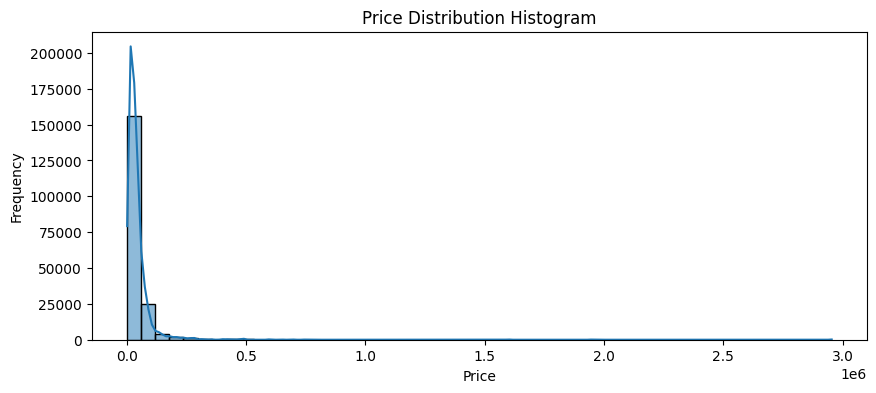

In [34]:
plt.figure(figsize=(10, 4))
sns.histplot(df_train['price'], bins=50, kde=True)
plt.title('Price Distribution Histogram')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

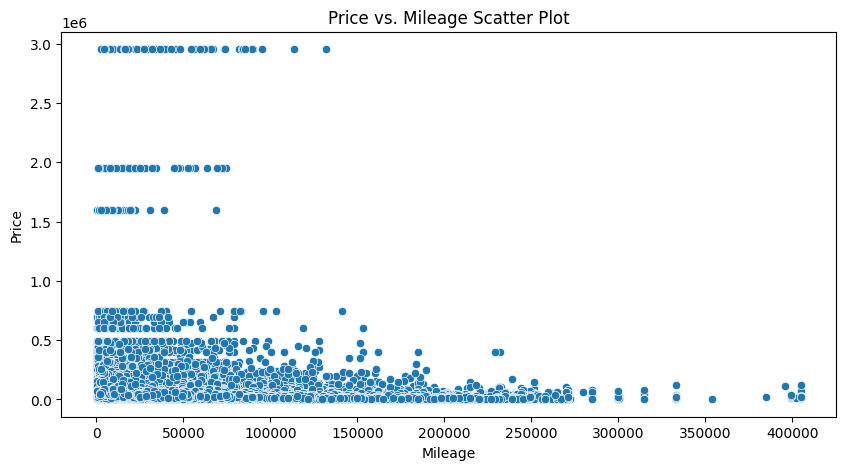

In [35]:
# price vs milage scatter plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df_train['milage'], y=df_train['price'])
plt.title('Price vs. Mileage Scatter Plot')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

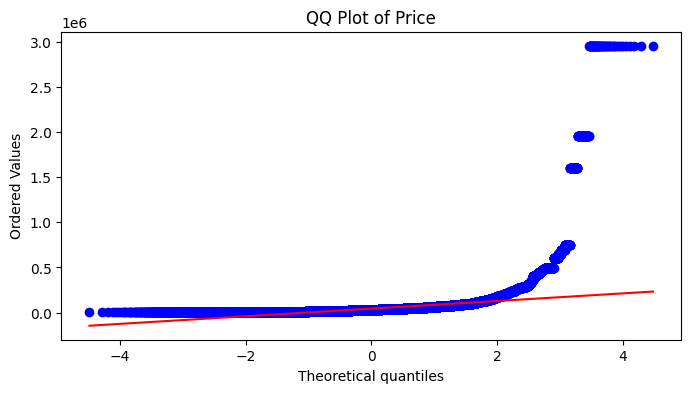

In [36]:
plt.figure(figsize=(8, 4))
stats.probplot(df_train['price'], dist="norm", plot=plt)
plt.title('QQ Plot of Price')
plt.show()

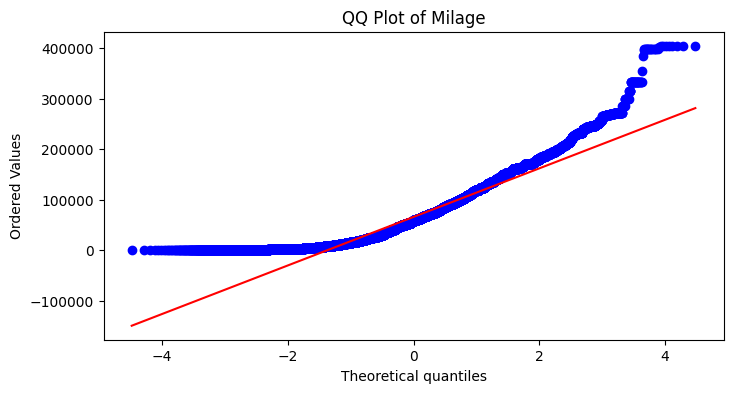

In [37]:
import scipy.stats as stats

plt.figure(figsize=(8, 4))
stats.probplot(df_train['milage'], dist="norm", plot=plt)
plt.title('QQ Plot of Milage')
plt.show()

In [38]:
#df_train, transformed = data_utils.power_transform(df_train, "milage")

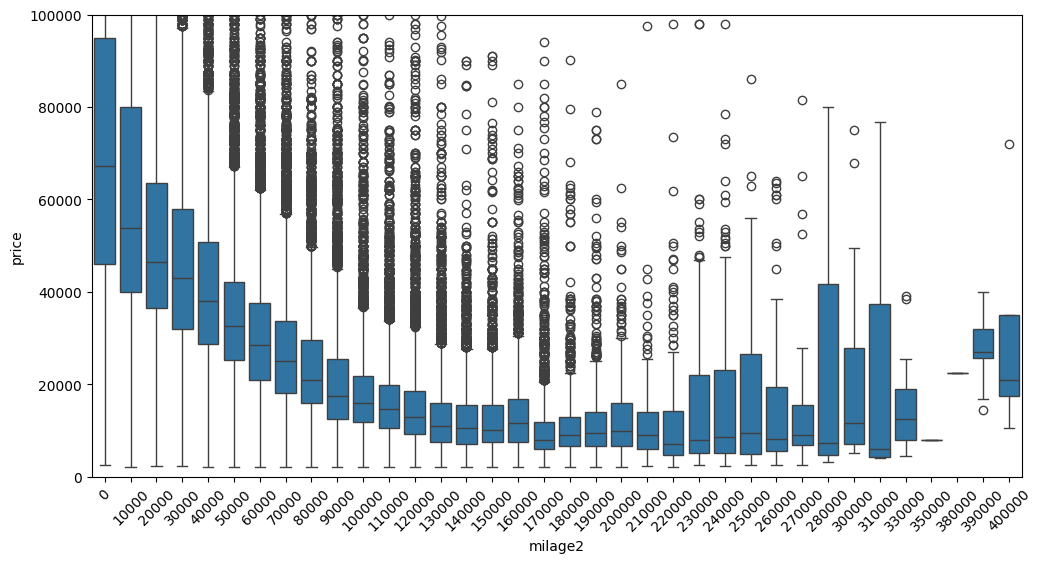

In [54]:
df_train["milage2"] = (df_train.milage//10_000)*10_000
plt.figure(figsize=(12,6))
sns.boxplot(x='milage2', y='price', data=df_train)
plt.ylim((0,100_000))
plt.xticks(rotation=45)
plt.show()

In [61]:
# for each object type column get the number of unique values sorted in descending order
df_train.select_dtypes("object").nunique().sort_values(ascending=False)

model           1897
engine          1117
ext_col          319
int_col          156
brand             57
transmission      52
fuel_type          7
accident           2
clean_title        1
dtype: int64

In [78]:
# find models whole value_counts is less than 10
df_train.model.value_counts()[df_train.model.value_counts() < 50]

model
F-250 XLT Super Duty             49
Rover Discovery LSE              49
Durango SRT                      49
Gladiator Willys                 49
ILX 2.0L w/Premium Package       49
                                 ..
IONIQ Plug-In Hybrid SEL          2
X5 3.0i                           1
X5 xDrive40e                      1
XLR Base                          1
Integra w/A-Spec Tech Package     1
Name: count, Length: 1051, dtype: int64

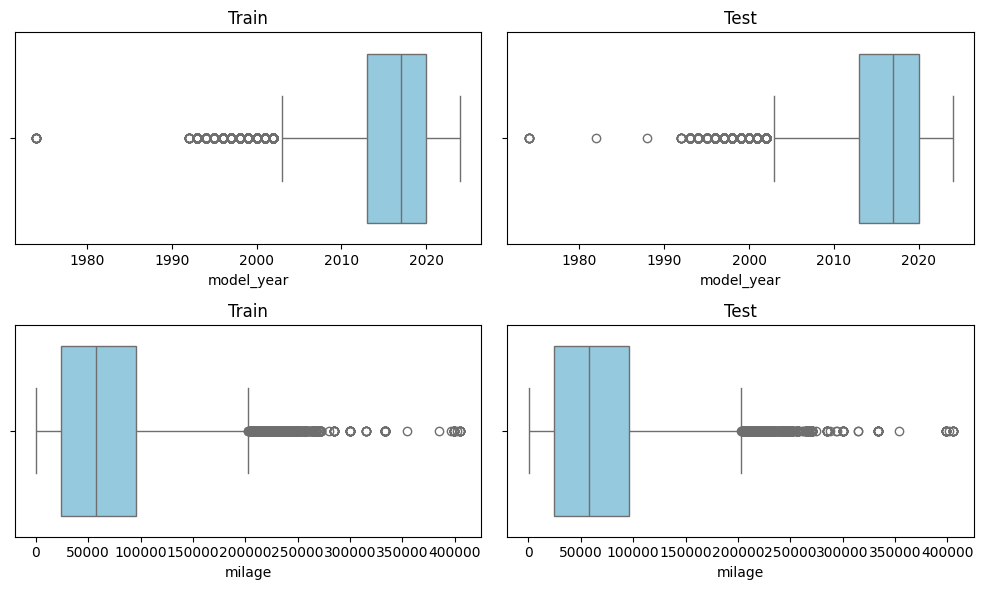

In [88]:
cols = ['model_year','milage']
data_utils.plot_box_plots(df_train, df_test, cols, fig_size=(10, 6))

In [ ]:
# # Calculate the correlation matrix
# correlation_matrix = df_train[feature_cols+[Config.TARGET_COL_NAME]].corr()

# # Plot the heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
# plt.title('Feature Correlation Heatmap')
# plt.tight_layout()
# plt.show()